The aim of this notebook is to improve on notebook 7.
This notebook contains:
- Loading Sentinel-2 data and WorldCover data, and saving to a Zarr file using Dask
- Model and dataset definitions for an 11-class Prithvi based classification model based on the WorldCover dataset
- A training function using DDP and `dask_pytorch_ddp` to finetune Prithvi
- Various tests for each component


Things I have done in order:
1. Ice Chunk + DDP + Batch Iterator - Compute Weights
  - This mainly helps with read and write speed of the zarr storage
2. Ice Chunk + DDP + cupy + dlpack + Batch Iterator
  - Interestingly this doesn't "show up" as Tasks on the Dask dashboard. Having a direct pipe to GPU memory seems to bypass Dask's task tracking
3. Dali + Ice Chunk + DDP + cupy + dlpack + Batch Iterator
  - Same behaviour as above


In [10]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

import boto3

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [11]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [12]:
import planetary_computer
from pystac_client import Client as PClient
import odc.stac
import warnings
warnings.filterwarnings('ignore')
from odc.geo.geobox import GeoBox
from odc.geo.geom import box as odc_box
import time as _time
from pystac_client.exceptions import APIError
import io
import zarr
import s3fs
import seaborn as sns
print("Data Loader Libraries Imported Successfully")

Data Loader Libraries Imported Successfully


In [13]:
import torch
from terratorch.registry import BACKBONE_REGISTRY

from dask_pytorch_ddp import dispatch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import torch.optim as optim
from datetime import datetime#, timedelta
import json
import torch.distributed as dist
import terratorch
from contextlib import nullcontext
from torch.cuda.amp import autocast, GradScaler
from s3torchconnector import S3Checkpoint

from torch.optim.lr_scheduler import StepLR
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from collections import Counter


from torch.distributed.fsdp import (
    FullyShardedDataParallel as FSDP,
    StateDictType,
    FullStateDictConfig,
)
from torchmetrics.functional import confusion_matrix as tm_confusion_matrix
from torchmetrics.functional.segmentation import mean_iou as tm_mean_iou
from torch.utils import dlpack

print("DL libraries imported successfully")

DL libraries imported successfully


In [14]:

import icechunk as ic
from icechunk.xarray import to_icechunk
from dataclasses import dataclass
from typing import Any, Callable, Dict, Optional, Sequence, Tuple

import cupy as cp

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
from nvidia.dali.plugin.pytorch import DALIGenericIterator

print("GPU helper libraries imported successfully")

GPU helper libraries imported successfully


# Dask Setup

In [36]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 2
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

Creating new cluster...


KeyboardInterrupt: 

In [17]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

# Data Prep
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [18]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"{bucket}/{base_prefix}"


repo_prefix = f"{userid}/{project_name}/training_dataset_v4-icechunk"

log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"

Successfully found configuration for deployment "csiro"


This implimentation uses `Dask-Pytorch-DDP`, `Ice Chunk` and `NVIDIA Dali`, if they don't come on the workers by default we need to install them.

In [19]:
#client.restart()

print("Installing dask-pytorch-ddp on all workers...")
client.run(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

# 2. Install on the Scheduler (This is the crucial missing step)
print("Installing dask-pytorch-ddp on the Scheduler...")
client.run_on_scheduler(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

#print("Installation initiated on both Scheduler and Workers. Now retry the DDP run.")

print("Installing icechunk (and zarr>=3) on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installing icechunk (and zarr>=3) on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

#print("Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.")

print("Installing Dali on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nvidia-dali-cuda120'])"
))

print("Installing Dali on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nvidia-dali-cuda120'])"
))

#print("Installation initiated on both Scheduler and Workers. Now retry the Dali build.")
print("Libraries installed on workers")


Installing dask-pytorch-ddp on all workers...
Installing dask-pytorch-ddp on the Scheduler...
Installing icechunk (and zarr>=3) on all workers...
Installing icechunk (and zarr>=3) on the Scheduler...
Installing Dali on all workers...
Installing Dali on the Scheduler...
Libraries installed on workers


# Fine Tuning Setup
We want to define:
- The model we will be fine tuning
- The dataset that will read from the s3 Bucket and feed data to the model during training
Both the model and dataset will usually depend on your specific use case but some genera things:
- Make sure to freeze tha backbone of the model
- Make sure the forward pass fits you dataset dims or vice versa
- Do any transformations you need within the dataset

For this Prithvi Model I have:
- Loadeed in the bakcbone
- Freeze the weights
- Added a decoader head
- A robust forward pass that goes through the backbone and to the new head

In [20]:
class PrithviBackbone(nn.Module):
    def __init__(self, embed_dim=1024, freeze=True, num_frames=3):
        super().__init__()
        self.encoder = BACKBONE_REGISTRY.build(
            "prithvi_eo_v2_300",
            pretrained=True,
            num_frames=num_frames,
        )
        if freeze:
            for p in self.encoder.parameters():
                p.requires_grad = False
        self.embed_dim = embed_dim

    def forward(self, x):
        # x: (B, C, T, H, W)
        assert x.dim() == 5
        B, C, T, H, W = x.shape

        features = self.encoder(x)
        if isinstance(features, (list, tuple)):
            features = features[-1]  # (B, L, C2)

        if features.dim() == 3:
            if features.shape[1] % (T * (H // 16) * (W // 16)) == 1:
                features = features[:, 1:, :]

            B2, L, C2 = features.shape
            t_patches = T
            h_patches = H // 16
            w_patches = W // 16
            assert L == t_patches * h_patches * w_patches

            features = features.view(B2, t_patches, h_patches, w_patches, C2)
            features = features.mean(dim=1)            # (B, H_p, W_p, C2)
            features = features.permute(0, 3, 1, 2)    # (B, C2, H_p, W_p)

        return features, (H, W)  # 2D feature map + original spatial size



class SegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, features, orig_hw):
        H, W = orig_hw
        logits = self.decode(features)
        logits = nn.functional.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        return logits



class PrithviSegmentation(nn.Module):
    def __init__(self, num_classes=11, freeze_backbone=True):
        super().__init__()
        self.backbone = PrithviBackbone(embed_dim=1024, freeze=freeze_backbone)
        self.head = SegmentationHead(in_channels=1024, num_classes=num_classes)

    def forward(self, x):
        features, orig_hw = self.backbone(x)
        logits = self.head(features, orig_hw)
        return logits

To make sure your dataset and model definition are correct you can run the above to chekc the input and output shape. Then you can build you decoder and dataset around that.

For this dataset we:
- Map the world Cover outputs to nicer class values
- Filter out any invalid values
- Convert to tensors
To help generalise the dataset, all datasets should return in the form of a dict

Zarr currently cannot reliably stream chunks from S3 directly into `cup.array`, so reads usually (always in my tests) go through CPU memory making it `numpy.array`.

Need to make the iterator inside the dali pipeline or it breaks

# Fine Tuning
In order to make this interchangeable with other problems, we will use a "Task" template and then fill it out with our specific needs.

Training has been broken up into steps so it is easy to replace with differnt model, tasks, etc...
We have:
- `to_device` and `wrap_model_with_fsdp` which applys the DDP libary, gets the optimiser and sends it to the workers
- `train_one_epoch` which handles the work of one full epoch: calculating loss and returning values in a nice format
- `evaluate` similar thing to the one_epoch function just handles the evaluation
- `train` which is the main training function
  - Handles setup
  - Splits the dataset into a train and validation dataset
  - Runs the epochs
  - Saves the logs of each epoch and the final model weights

Since this uses NVIDIA Dali under the hood, it can only run on GPUs.

In [21]:
from accelerated_io import GeoBatchSpec, BatchAdapter, get_num_samples, make_dali_iterator
from training_helpers import train_one_epoch, evaluate, SegmentationTask, wrap_model_with_fsdp, train_one_epoch_log
from label_mappers import WorldCoverLabelMapper

# TODO: Torch elestic for membership changes during training????
# Otherwise just use restart from checkpoint


def train(repo_prefix,
        s3_bucket,
        output_dir,
        log_dir,
        num_epochs,
        batch_size,
        learning_rate,
        snapshot_id=None, 
        checkpoint_file=None, 
        enable_timing_logs= False,
        val_split: float = 0.2,
        seed: int = 42,
    ):
    start_epoch = 0

    num_classes = 11

    rank = dist.get_rank()
    world_size = dist.get_world_size()
    
    if torch.cuda.is_available():
        local_rank = int(os.environ.get("LOCAL_RANK", "0"))
        torch.cuda.set_device(local_rank)
        device = torch.device("cuda", local_rank)
    else:
        local_rank = 0
        device = torch.device("cpu")

    label_mapper = WorldCoverLabelMapper(num_classes=num_classes)
    n = get_num_samples(s3_bucket, repo_prefix, snapshot_id=snapshot_id)
    indices = np.arange(n)

    train_idx, val_idx = train_test_split(
        indices, test_size=val_split, random_state=seed, shuffle=True
    )

    train_idx_rank = train_idx[rank::world_size]
    val_idx_rank = val_idx[rank::world_size]

    spec = GeoBatchSpec(x_key="features", y_key="labels")
    label_lut = label_mapper.make_lut(255)
    adapter = BatchAdapter(label_lut=label_lut)

    train_dl = make_dali_iterator(
        base_indices=train_idx_rank,
        batch_size=batch_size,
        device_id=local_rank,
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        shuffle=True,
        spec=spec,
        adapter=adapter
    )
    val_dl = make_dali_iterator(
        base_indices=val_idx_rank,
        batch_size=batch_size,
        device_id=local_rank,
        bucket=s3_bucket,
        repo_prefix=repo_prefix,
        snapshot_id=snapshot_id,
        shuffle=False,
        spec=spec,
        adapter=adapter
    )

    base_model = PrithviSegmentation(num_classes=num_classes).to(device)
    model, optimizer = wrap_model_with_fsdp(base_model, lr=learning_rate)
    model_without_ddp = model.module

    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
    task = SegmentationTask(num_classes=num_classes, class_weights=None)

    val_loss_min = np.Inf
    checkpoint_connection = S3Checkpoint(region="ap-southeast-2")

    # ---- Optional checkpoint restore ----
    if checkpoint_file:
        with checkpoint_connection.reader(
            f"s3://{s3_bucket}/{checkpoint_file}"
        ) as reader:
            checkpoint = torch.load(reader, map_location=device)
        model_without_ddp.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        start_epoch = checkpoint["epoch"] + 1
        val_loss_min = checkpoint["val_loss_min"]

    # collect all per-epoch logs on rank 0
    all_logs = []

    # ---- Epoch loop ----
    for epoch in range(start_epoch, num_epochs):
        if enable_timing_logs:
            train_stats = train_one_epoch_log(model, optimizer, scheduler, task, train_dl, device, log_every=5)
        else:
            train_stats = train_one_epoch(model, optimizer, scheduler, task, train_dl, device)

        val_stats = evaluate(model, task, val_dl, device)

        train_loss = float(train_stats["loss"])
        train_accuracy = float(train_stats["accuracy"])
        val_loss = float(val_stats["loss"])
        val_accuracy = float(val_stats["accuracy"])

        log = {
            "worker_rank": worker_rank,
            "world_size": world_size,
            "epoch": epoch,
            "start_time": datetime.now().isoformat(),
            "lr": float(optimizer.param_groups[0]["lr"]),
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "end_time_val": datetime.now().isoformat(),
            "repo_prefix": repo_prefix,
            "snapshot_id": snapshot_id,
            "num_classes": num_classes,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
        }
        if enable_timing_logs:
            log.update({
                "t_fetch": float(train_stats.get("t_fetch", 0.0)),
                "t_to_device": float(train_stats.get("t_to_device", 0.0)),
                "t_step": float(train_stats.get("t_step", 0.0)),
                "timing_samples": int(train_stats.get("timing_samples", 0)),
                "num_batches": int(train_stats.get("num_batches", 0)),
            })

        dist.barrier()
        if worker_rank == 0:
            all_logs.append(log)

            if val_loss < val_loss_min:
                val_loss_min = val_loss
                best_path = output_dir + "model_best.pth"
                with FSDP.state_dict_type(
                    model,
                    StateDictType.FULL_STATE_DICT,
                    FullStateDictConfig(rank0_only=True),
                ):
                    full_state = model.state_dict()

                checkpoint = {
                    "model": full_state,
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "val_loss_min": val_loss_min,
                }
                with checkpoint_connection.writer(f"s3://{s3_bucket}/{best_path}") as writer:
                    torch.save(checkpoint, writer)

    # ---- Write single JSONL log file at end ----
    if worker_rank == 0 and len(all_logs) > 0:
        run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        jsonl_key = log_dir + f"training_logs_{run_id}.jsonl"

        buf = io.StringIO()
        for row in all_logs:
            buf.write(json.dumps(row) + "\n")

        boto3.client("s3").put_object(
            Body=buf.getvalue().encode("utf-8"),
            Bucket=s3_bucket,
            Key=jsonl_key,
        )

    return

# Sending it to dask
Before we send this to the cluster, we need to upload any files we are importing so the workers can use them. 

In [35]:
import time
from dask_ddp_wrapper import run_elasticish_ddp_on_dask, GangConfig

client.restart()
client.upload_file("accelerated_io.py")
client.upload_file("training_helpers.py")
client.upload_file("label_mappers.py")

# TODO: Create my own wrappr instead of using dask-pytorch-ddp
# Start with dispatch then work on returning values from cluster (Rather than saving to S3 workaround)

train_kwargs = dict(
    repo_prefix=repo_prefix,
    #snapshot_id=snapshot_id,
    s3_bucket=bucket,
    output_dir=output_dir,
    log_dir=log_dir,
    num_epochs=2,
    batch_size=8,
    learning_rate=0.001,
    num_classes=11
)
t0 = time.time()
run_elasticish_ddp_on_dask(
    client=client,
    train_fn=train,
    train_kwargs=train_kwargs,
    cfg=GangConfig(max_restarts=200, master_port=29500),
    #resolve_checkpoint=resolve_latest,
)
#client.gather(futs)
t1 = time.time()
print("Done Training")

print(f"Total training time: {t1 - t0:.2f} s")

AttributeError: 'NoneType' object has no attribute 'restart'

Loaded: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/logs/training_logs_20251218_055854.jsonl
 epoch  worker_rank  t_fetch  t_to_device   t_step  timing_samples  num_batches
     0            0 0.907841     0.000042 3.162643              32           32
     1            0 0.934892     0.000034 3.166334              32           32

Per-epoch mean timings (seconds):
 epoch  t_fetch  t_to_device   t_step
     0 0.907841     0.000042 3.162643
     1 0.934892     0.000034 3.166334


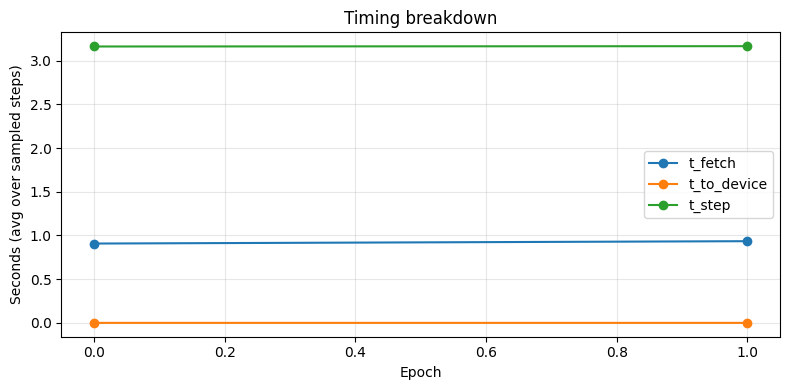

In [47]:
import boto3, json
import pandas as pd
import matplotlib.pyplot as plt

def load_latest_training_log(s3_bucket: str, log_dir_prefix: str):
    """
    log_dir_prefix should be the same prefix you pass as log_dir, e.g. "logs/".
    Assumes keys like: f"{log_dir_prefix}training_logs_YYYYmmdd_HHMMSS.jsonl"
    """
    s3 = boto3.client("s3")

    resp = s3.list_objects_v2(Bucket=s3_bucket, Prefix=log_dir_prefix)
    contents = resp.get("Contents", [])
    keys = [o["Key"] for o in contents if o["Key"].endswith(".jsonl") and "training_logs_" in o["Key"]]
    if not keys:
        raise FileNotFoundError(f"No training_logs_*.jsonl found under s3://{s3_bucket}/{log_dir_prefix}")

    latest_key = max(keys)  # timestamp is in filename, so lexicographic works
    obj = s3.get_object(Bucket=s3_bucket, Key=latest_key)
    text = obj["Body"].read().decode("utf-8")

    rows = [json.loads(line) for line in text.splitlines() if line.strip()]
    df = pd.DataFrame(rows)
    return latest_key, df


def inspect_timing(df: pd.DataFrame):
    cols = ["epoch", "worker_rank", "t_fetch", "t_to_device", "t_step", "timing_samples", "num_batches"]
    cols = [c for c in cols if c in df.columns]
    print(df[cols].sort_values(["epoch", "worker_rank"]).to_string(index=False))

    # Aggregate across ranks per epoch (mean)
    agg = df.groupby("epoch", as_index=False)[[c for c in ["t_fetch","t_to_device","t_step"] if c in df.columns]].mean()
    print("\nPer-epoch mean timings (seconds):")
    print(agg.to_string(index=False))

    # Simple plot
    plt.figure(figsize=(8,4))
    for c in ["t_fetch","t_to_device","t_step"]:
        if c in agg.columns:
            plt.plot(agg["epoch"], agg[c], marker="o", label=c)
    plt.xlabel("Epoch")
    plt.ylabel("Seconds (avg over sampled steps)")
    plt.title("Timing breakdown")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# ---- use it ----
latest_key, df = load_latest_training_log(bucket, log_dir)
print("Loaded:", f"s3://{bucket}/{latest_key}")
inspect_timing(df)



# Testing and Results
A function containing common testing functions post training. This is an example of what some local testing may be like;

In [27]:
def plot_training_history(bucket, userid, project_name):
    """Plot training curves from latest JSONL log file"""
    
    log_dir = f"{userid}/{project_name}/logs/"
    s3 = boto3.client("s3")
    
    # List all JSONL log files for this project
    resp = s3.list_objects_v2(Bucket=bucket, Prefix=log_dir)
    jsonl_keys = [
        obj["Key"] for obj in resp.get("Contents", [])
        if obj["Key"].endswith(".jsonl")
    ]
    
    if not jsonl_keys:
        print("No JSONL log files found under", log_dir)
        return
    
    jsonl_keys.sort()
    latest_key = jsonl_keys[-1]
    print("Using log file:", latest_key)
    
    body = s3.get_object(Bucket=bucket, Key=latest_key)["Body"].read().decode("utf-8")
    logs = [json.loads(line) for line in body.splitlines() if line.strip()]
    logs = sorted(logs, key=lambda x: x["epoch"])
    
    epochs = [log["epoch"] for log in logs]
    train_losses = [log["train_loss"] for log in logs]
    val_losses = [log["val_loss"] for log in logs]
    train_accuracies = [log["train_accuracy"] for log in logs]
    val_accuracies = [log["val_accuracy"] for log in logs]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker="o", label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, marker="o", label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker="o", label="Training Accuracy", linewidth=2)
    plt.plot(epochs, val_accuracies, marker="o", label="Validation Accuracy", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [30]:
def test_model(
    test_repo_prefix, s3_bucket, best_model_key, test_snapshot_id=None,
    num_classes: int = 11, batch_size: int = 8, device_id: int = 0,
    ignore_index: int = 255, userid=None, project_name="training_test_project",
    show_training_history=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if show_training_history and userid:
            plot_training_history(s3_bucket, userid, project_name)
    # --- Data ---
    label_mapper = WorldCoverLabelMapper(num_classes=num_classes, ignore_index=ignore_index)
    spec = GeoBatchSpec(x_key="features", y_key="labels", patch_hw=(224, 224))
    adapter = BatchAdapter(label_mapper=label_mapper)

    # --- Indices (no Dataset needed) ---
    n = get_num_samples(
        bucket=s3_bucket,
        repo_prefix=test_repo_prefix,
        snapshot_id=test_snapshot_id,
        x_key=spec.x_key,
    )
    test_indices = np.arange(n)

    test_dl = make_dali_iterator(
        base_indices=test_indices,
        batch_size=batch_size,
        device_id=device_id,
        bucket=s3_bucket,
        repo_prefix=test_repo_prefix,
        snapshot_id=test_snapshot_id,
        #device=device,
        shuffle=False,
        spec=spec,
        adapter=adapter,
    )

    # --- Model + checkpoint ---
    model = PrithviSegmentation(
        num_classes=num_classes,
        freeze_backbone=True,
    ).to(device)

    checkpoint_connection = S3Checkpoint(region="ap-southeast-2")
    with checkpoint_connection.reader(best_model_key) as reader:
        checkpoint = torch.load(reader, map_location=device)

    state_dict = checkpoint["model"] if "model" in checkpoint else checkpoint
    model.load_state_dict(state_dict)
    model.eval()

    task = SegmentationTask(
        num_classes=num_classes,
        class_weights=None,
        ignore_index=ignore_index,
    )

    all_preds_list = []
    all_targets_list = []

    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    # --- Loop over test set ---
    with torch.no_grad():
        for batch in test_dl:
            batch = batch[0]  # DALI iterator: [ {'inputs':..., 'labels':...} ]

            images = batch["inputs"].to(device)   # [B, C, T, H, W] or [B, C, H, W]
            labels = batch["labels"].to(device)   # [B, H, W]

            batch_for_task = {"labels": labels}

            logits = model(images)                # [B, num_classes, H, W]
            loss = task.compute_loss(logits, batch_for_task)

            preds = logits.argmax(dim=1)          # [B, H, W]
            valid = labels != ignore_index        # bool mask

            # basic stats on valid pixels only
            correct = (preds[valid] == labels[valid]).sum()
            pixels = valid.sum()

            total_loss += loss.item() * float(pixels)
            total_correct += int(correct)
            total_pixels += int(pixels)

            all_preds_list.append(preds.detach().cpu())
            all_targets_list.append(labels.detach().cpu())

    if total_pixels > 0:
        avg_loss = total_loss / total_pixels
        pixel_acc = total_correct / total_pixels
    else:
        avg_loss = 0.0
        pixel_acc = 0.0

    # --- Stack predictions and labels ---
    all_preds = torch.cat(all_preds_list, dim=0)    # [N, H, W]
    all_targets = torch.cat(all_targets_list, dim=0)  # [N, H, W]

    print("Label min/max:", int(all_targets.min()), int(all_targets.max()))
    print("Unique labels (sample):", torch.unique(all_targets)[:20])

    # Mask out ignore for global metrics
    valid_mask = all_targets != ignore_index
    preds_valid = all_preds[valid_mask]             # [M]
    targets_valid = all_targets[valid_mask]         # [M]

    # --- Mean IoU (overall + per class) ---
    # reshape to [1, H, W] form (mean_iou expects batch/spatial dims)
    preds_iou = preds_valid.view(1, -1, 1)          # [1, M, 1]
    targets_iou = targets_valid.view(1, -1, 1)      # [1, M, 1]

    miou_per_class = tm_mean_iou(
        preds=preds_iou,
        target=targets_iou,
        num_classes=num_classes,
        include_background=True,
        per_class=True,
        input_format="index",
    )  # shape [num_classes]
    miou_per_class = miou_per_class.view(-1)
    miou_overall = torch.nanmean(miou_per_class).item()

    # --- Confusion matrix (valid pixels only) ---
    cm = tm_confusion_matrix(
        preds_valid,
        targets_valid,
        num_classes=num_classes,
        task="multiclass",
    ).float()  # [num_classes, num_classes]

    true_positives = torch.diag(cm)
    support = cm.sum(dim=1)
    per_class_acc = true_positives / (support + 1e-8)

    # === VISUALIZATIONS ===
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. CONFUSION MATRIX (normalized)
    cm_norm = cm / (cm.sum(dim=1, keepdim=True) + 1e-8)
    sns.heatmap(cm_norm.cpu().numpy(), annot=False, cmap='Blues', 
                xticklabels=range(num_classes), yticklabels=range(num_classes),
                ax=axes[0,0], cbar_kws={'label': 'Normalized Frequency'})
    axes[0,0].set_title('Confusion Matrix (Normalized)')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('True')
    
    # 2. PER-CLASS IoU BAR CHART
    valid_classes = torch.isfinite(miou_per_class)
    axes[0,1].bar(range(num_classes), miou_per_class.cpu().numpy(), 
                  color='skyblue', alpha=0.7)
    axes[0,1].set_title('Mean IoU per Class')
    axes[0,1].set_xlabel('Class')
    axes[0,1].set_ylabel('mIoU')
    axes[0,1].set_ylim(0, 1)
    
    # 3. PER-CLASS ACCURACY BAR CHART
    axes[1,0].bar(range(num_classes), per_class_acc.cpu().numpy(), 
                  color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Accuracy per Class')
    axes[1,0].set_xlabel('Class')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_ylim(0, 1)
    axes[1,1].axis('off')  # ← THIS FIXES THE BLANK GRAPH

    plt.tight_layout()
    plt.show()
    
    # 4. SAMPLE PREDICTION vs GROUND TRUTH (first image)
    if len(all_preds) > 0:
        sample_idx = 0
        fig_sample, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Ground truth
        ax1.imshow(all_targets[sample_idx].numpy(), cmap='tab20', vmin=0, vmax=num_classes-1)
        ax1.set_title('Ground Truth')
        ax1.axis('off')
        
        # Prediction
        ax2.imshow(all_preds[sample_idx].numpy(), cmap='tab20', vmin=0, vmax=num_classes-1)
        ax2.set_title('Prediction')
        ax2.axis('off')
        
        # Overlay (GT + Pred)
        overlay = 0.5 * all_targets[sample_idx].numpy() + 0.5 * all_preds[sample_idx].numpy()
        ax3.imshow(overlay, cmap='tab20', vmin=0, vmax=num_classes-1)
        ax3.set_title('Overlay (GT + Pred)')
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    plt.tight_layout()
    plt.show()
    
    # === SUMMARY TABLE ===
    summary_data = {
        'Metric': ['Loss', 'Pixel Acc', 'mIoU'],
        'Value': [f'{avg_loss:.4f}', f'{pixel_acc:.4f}', f'{miou_overall:.4f}']
    }
    print("\n" + "="*50)
    print("TEST SUMMARY")
    print("="*50)
    import pandas as pd
    print(pd.DataFrame(summary_data).to_string(index=False))
    
    return {
        "loss": avg_loss, "pixel_accuracy": pixel_acc, "miou": miou_overall,
        "miou_per_class": miou_per_class, "confusion_matrix": cm,
        "per_class_accuracy": per_class_acc,
    }

Using log file: AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/logs/training_logs_20251218_051046.jsonl


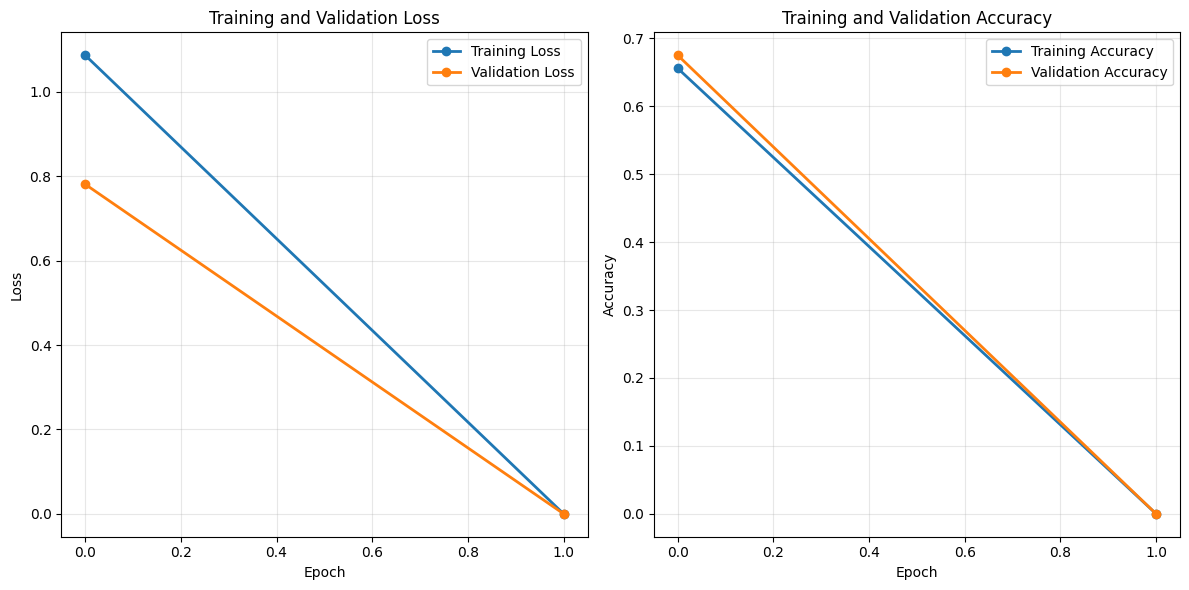

RuntimeError: no_copy is supported only for the same data source device type as operator. Received: CPU input for GPU operator.

In [31]:

output_dir = f"{userid}/{project_name}/models/"
test_repo_prefix="AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v4_test-icechunk"

best_model_uri = f"s3://{bucket}/{output_dir}model_best.pth"
test_model(test_repo_prefix, bucket, best_model_uri, test_snapshot_id=None, userid=userid)

# Be a good Dask user and close your cluster when you are done

In [18]:
client.close()
cluster.shutdown()